In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from dlem import util
from dlem import load_model, load_reader
import seaborn
import tqdm

In [2]:
def dlem(left, right, curr_diag, index_diag, n, transform=True, eps=1e-6):

    diag_len = n - index_diag

    index_in_left = range(index_diag, n-1)
    index_in_right = range(1, n-index_diag)
    index_out_left = range(index_diag+1, n)
    index_out_right = range(0, n-index_diag-1)

    index_curr_diag_left = range(0, diag_len-1)
    index_curr_diag_right = range(1, diag_len)

    mass_in = curr_diag[:, index_curr_diag_right] * right[:, index_in_right]
    mass_in += curr_diag[:, index_curr_diag_left] * left[:, index_in_left]

    mass_out = right[:, index_out_right] + left[:, index_out_left] + eps

    next_diag_pred = mass_in / mass_out

    if transform:
        next_diag_pred = torch.log(next_diag_pred)
        next_diag_pred = next_diag_pred - torch.mean(next_diag_pred)

    return next_diag_pred


In [3]:
dev = torch.device('cuda')

In [4]:
res = 10000
window_size = 300
stride = 150

In [5]:
data = load_reader("datareader_cooler")(
    "../../../loopExtraction/data/4DNFI9GMP2J8.mcool",
    res,
    window_size,
    stride,
    chrom_subset=["chr1", "chr10"],
)

In [6]:
data.filter_out_dataset(0.05)
dataloader = torch.utils.data.DataLoader(data, batch_size=5, shuffle=True)

In [7]:
def weighted_mse(output, target):
    loss = torch.mean((output - target)**2 * torch.exp(target))
    return loss

In [8]:
num_epoch = 100

In [9]:
diag_end=200
diag_start=1

In [10]:
init_diag = torch.ones((300, 300)) * 300

In [11]:
#loss = weighted_mse
loss = torch.nn.MSELoss()

In [12]:
architecture = load_model("dlemcoder")
model = architecture(300)
model = model.to(dev)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
#torch.isnan(model.conv(torch.log(log_normed))).any()
#x = model.conv(torch.log(log_normed))
#x = torch.cat([x.sum(axis=-2), x.sum(axis=-1)], axis=1)
#torch.isnan(x).any()
#torch.isnan(model.mix_lr(x)).any()

In [14]:
loss_arr = []
best_loss = np.inf
for e in range(num_epoch):
    for i, (patch, perc_nan, _, _, _) in enumerate(dataloader):
        if i == len(dataloader):
            break
        log_normed = torch.exp(util.diagonal_normalize(torch.log(patch))).unsqueeze(1)
        log_normed = log_normed.to(dev)
        optimizer.zero_grad()
        loss_total = 0
        #pred_map = model.contact_map_prediction(init_diag)
        #pred_map = torch.exp(util.diagonal_normalize(torch.log(pred_map)))
        pred = model(torch.triu(torch.log(log_normed)), diag_start, diag_end, True)
        for n, diag_i in enumerate(range(diag_start, diag_end)):
            loss_total += loss(pred[n], torch.log(util.get_diags(log_normed, diag_i+1)).squeeze())
        loss_total.backward()
        optimizer.step()
        loss_arr.append(loss_total.detach().cpu().numpy())
        if loss_arr[-1] < best_loss:
            best_loss = loss_arr[-1]
            best_model = model.state_dict()

    print(f'{int((e+1)/num_epoch*100):3}/100: '
        f'loss = {loss_total:.3f}',
        flush=True, end='\r')

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


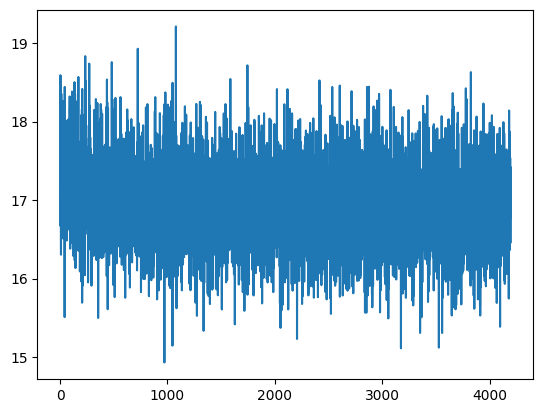

In [15]:
plt.plot(loss_arr)

In [16]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [17]:
lr = torch.cat([torch.triu(torch.log(log_normed)).sum(axis=-2), torch.triu(torch.log(log_normed)).sum(axis=-1)], axis=1)

In [18]:
lr.shape

torch.Size([5, 2, 300])

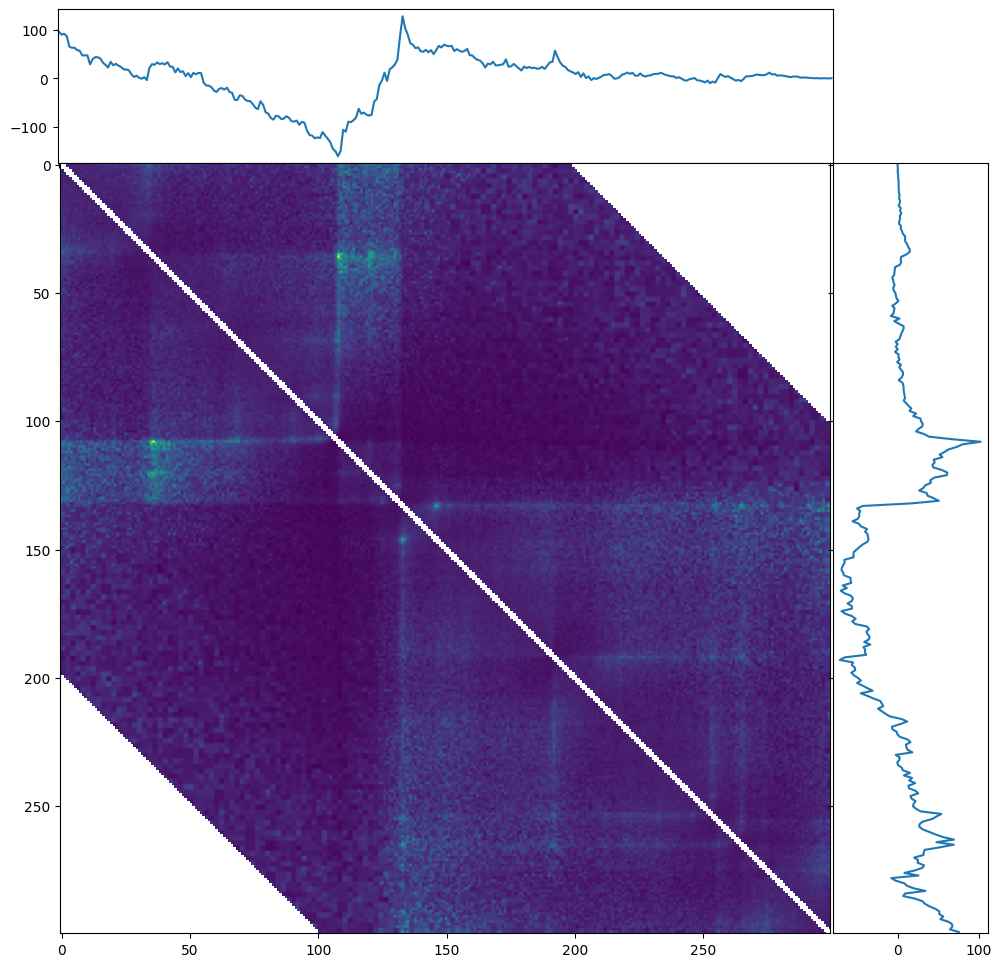

In [19]:
util.plot_results(log_normed[1, 0].detach().cpu().numpy(),
                  log_normed[1, 0].detach().cpu().numpy(),
                  (lr[1, 0, :].detach().cpu().numpy(),
                   lr[1, 1, :].detach().cpu().numpy()),
                   ignore_i = diag_start,
                   ignore_i_off=diag_end)

In [20]:
patches_pred = torch.zeros((5, 300, 300)).to(dev)
for n, diag_i in enumerate(range(diag_start, diag_end)):
    patches_pred += torch.diag_embed(pred[n], diag_i+1)

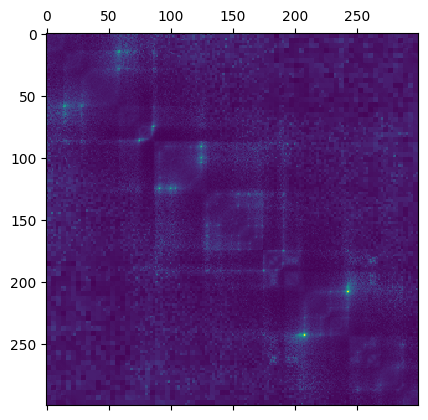

In [21]:
plt.matshow(log_normed[0,0].detach().cpu().numpy())

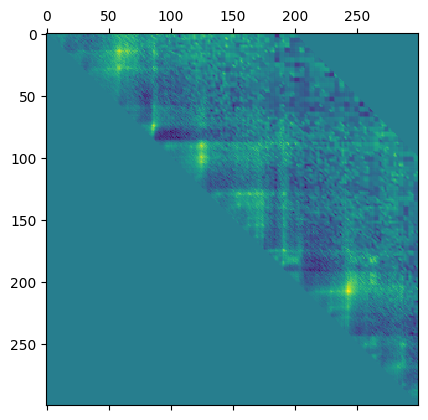

In [22]:
plt.matshow(patches_pred[0].detach().cpu().numpy())

In [23]:
init_diag = torch.ones((5, 300)) * 300
init_diag = init_diag.to(dev)

In [24]:
init_diag.shape

torch.Size([5, 300])

In [28]:
patches_pred = torch.zeros((5, 300, 300)).to(dev)
x = torch.log(log_normed)
left_ = model.scan_left(x).squeeze()
right_ = model.scan_right(x).squeeze()
lr = torch.concat([left_, right_], axis=1)
lr = model.conv(lr)
lr = model.mix_lr(lr)
left = lr[:, 0, :]
right = lr[:, 1, :]
next_diag_pred = dlem(left, right, init_diag, 0, x.shape[-1], False)
patches_pred += torch.diag_embed(next_diag_pred, 1)
for index_diag in range(1, diag_end):
    next_diag_pred = dlem(left, right, next_diag_pred, index_diag, x.shape[-1], False)
    patches_pred += torch.diag_embed(next_diag_pred, index_diag+1)

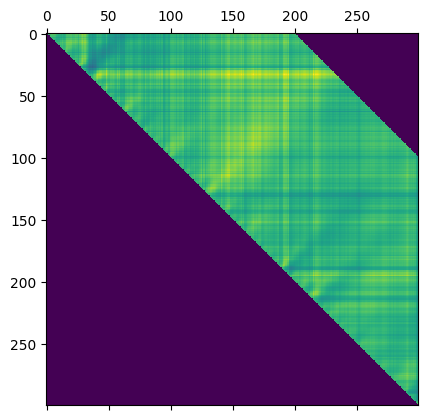

In [29]:
plt.matshow(patches_pred[2].detach().cpu().numpy())

In [ ]:
torch.diag_embed(pred[0], 2).shape

torch.Size([5, 300, 300])

In [ ]:
inter_lr = model.conv(lr)
left_right = model.mix_lr(inter_lr)

In [ ]:
inter_lr.shape

torch.Size([5, 25, 300])

In [ ]:
left_right.shape

torch.Size([5, 2, 300])

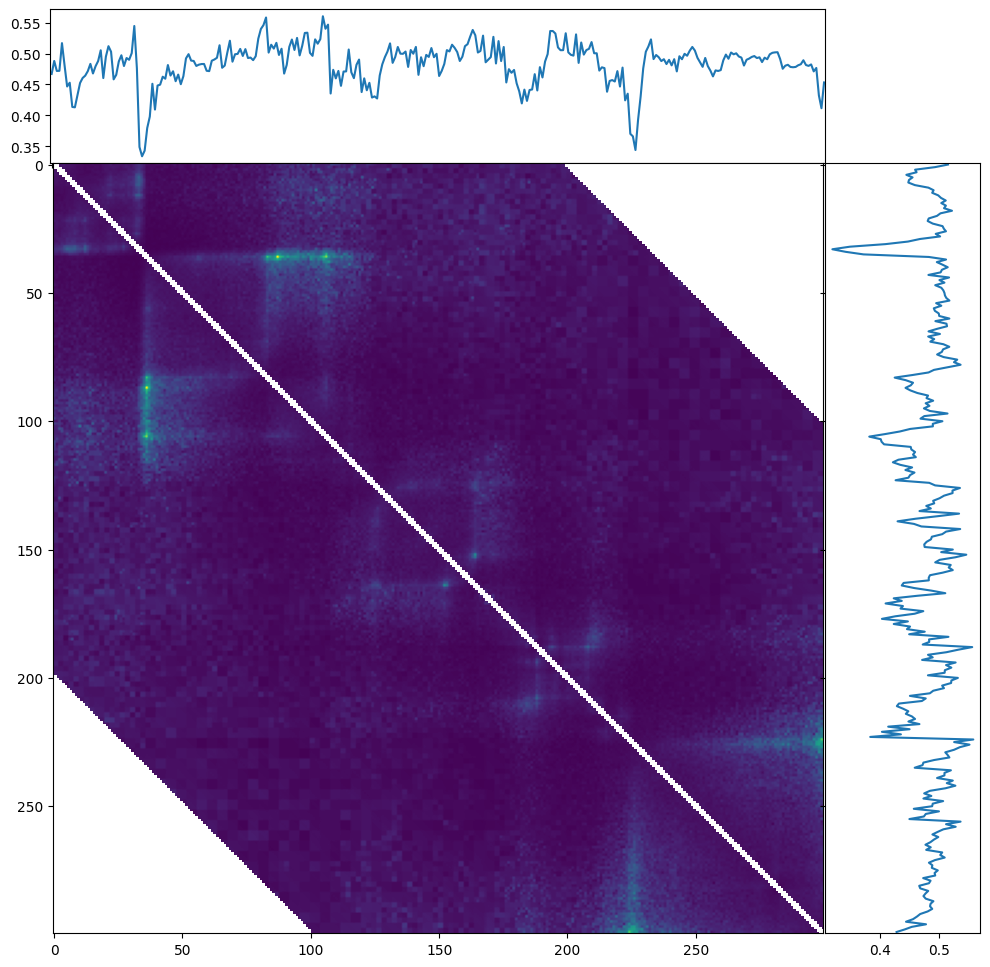

In [ ]:
util.plot_results(log_normed[1, 0].detach().cpu().numpy(),
                  log_normed[1, 0].detach().cpu().numpy(),
                  (left_right[1, 0, :].detach().cpu().numpy(),
                   left_right[1, 1, :].detach().cpu().numpy()),
                   ignore_i = diag_start,
                   ignore_i_off=diag_end)

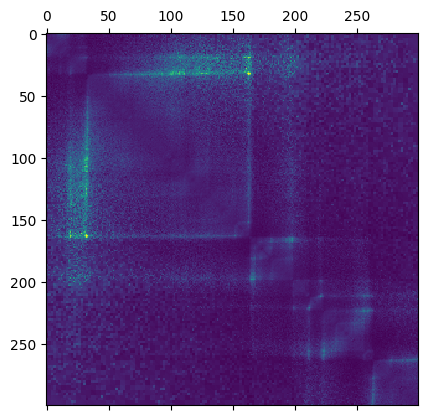

In [ ]:
plt.matshow(log_normed[1, 0].detach().cpu().numpy())

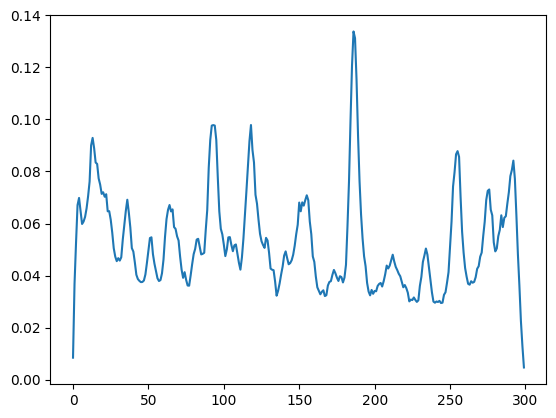

In [ ]:
plt.plot(model.left[0].detach().cpu().numpy())

In [ ]:
log_normed[0].shape

(1, 300, 300)

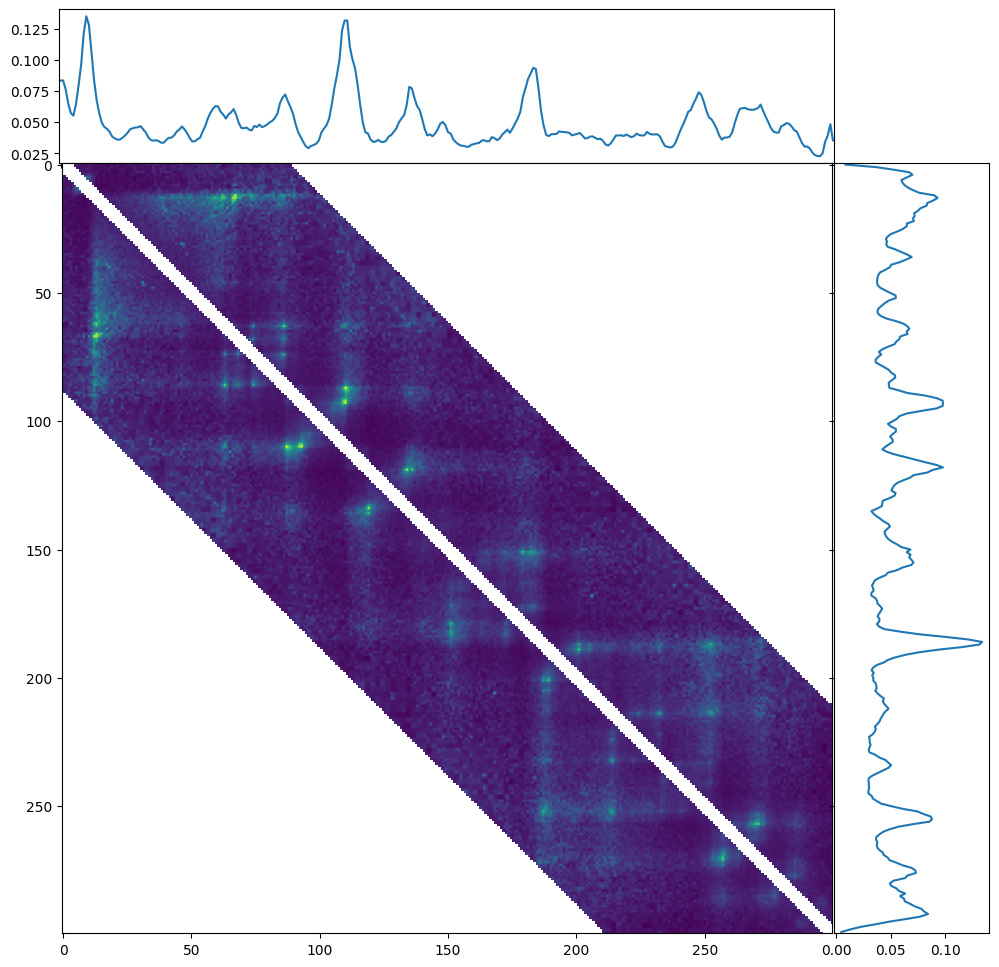

In [ ]:
util.plot_results(log_normed[0,0],
                  log_normed[0,0],
                  (model.left[0].detach().cpu().numpy(),
                   model.right[0].detach().cpu().numpy()))